In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
import matplotlib.font_manager as fm 
import matplotlib

font_path = 'C:\\Windows\\Fonts\\gulim.ttc' 
font = fm.FontProperties(fname=font_path).get_name() 
matplotlib.rc('font', family=font) 

In [7]:
# 데이터 로드
df = pd.read_csv('./data/merged_data.csv')

df = df.drop(['폐업_점포_수', '폐업_영업_개월_평균', '서울시_폐업_영업_개월_평균', '기준_년분기_코드'], axis=1)

In [8]:
# 레이블 인코딩
from sklearn.preprocessing import LabelEncoder

cols = ['자치구_코드_명', '서비스_업종_코드_명', '상권_변화_지표']

for col in cols:
    encoder = LabelEncoder()
    df[col] = encoder.fit_transform(df[col])
    print(encoder.classes_)

['강남구' '강동구' '강북구' '강서구' '관악구' '광진구' '구로구' '금천구' '노원구' '도봉구' '동대문구' '동작구'
 '마포구' '서대문구' '서초구' '성동구' '성북구' '송파구' '양천구' '영등포구' '용산구' '은평구' '종로구' '중구'
 '중랑구']
['PC방' '가구' '가방' '가전제품' '가전제품수리' '고시원' '골프연습장' '네일숍' '노래방' '당구장' '문구'
 '미곡판매' '미용실' '반찬가게' '부동산중개업' '분식전문점' '서적' '섬유제품' '세탁소' '수산물판매' '슈퍼마켓'
 '스포츠 강습' '스포츠클럽' '시계및귀금속' '신발' '안경' '애완동물' '양식음식점' '여관' '예술학원' '완구'
 '외국어학원' '운동/경기용품' '육류판매' '의료기기' '의약품' '인테리어' '일반교습학원' '일반의류' '일반의원'
 '일식음식점' '자동차미용' '자동차수리' '자전거 및 기타운송장비' '전자상거래업' '제과점' '조명용품' '중식음식점'
 '철물점' '청과상' '치과의원' '치킨전문점' '커피-음료' '컴퓨터및주변장치판매' '패스트푸드점' '편의점' '피부관리실'
 '한식음식점' '한의원' '핸드폰' '호프-간이주점' '화장품' '화초']
['HH' 'HL' 'LH' 'LL']


In [9]:
# 전체 데이터의 75%을 기준으로 등급 나누기
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

df['폐업률_등급'] = pd.qcut(df['폐업_률'], q=[0, 0.75, 1.0], labels=[0, 1])

X = df.drop(['폐업_률', '폐업률_등급'], axis=1) 
y_class = df['폐업률_등급']

smote = SMOTE(random_state=42)
X_resample, y_resample = smote.fit_resample(X, y_class)

X_train, X_test, y_train, y_test = train_test_split(
    X_resample, y_resample, test_size=0.2, random_state=42, stratify=y_resample
)

In [ ]:
import optuna
from catboost import CatBoostClassifier
from sklearn.model_selection import cross_val_score

# 목적 함수 정의
def objective(trial):
    params = {
        'depth': trial.suggest_int('depth', 1, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, step=0.01),
        'iterations': trial.suggest_int('iterations', 100, 900, step=100),
        'l2_leaf_reg': trial.suggest_int('l2_leaf_reg', 1, 10),
        'bagging_temperature': trial.suggest_int('bagging_temperature', 0, 5),
        'random_strength': trial.suggest_int('random_strength', 1, 10),
        'border_count': trial.suggest_categorical('border_count', [32, 64, 128]),
        'verbose': 0,
        'random_state': 42
    }

    model = CatBoostClassifier(**params)

    # 교차 검증 정확도 평균을 최적화 대상으로 설정
    score = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1)
    return score.mean()

# 스터디 생성 및 최적화 
study = optuna.create_study(direction='maximize')  # 정확도 최대화가 목적
study.optimize(objective, n_trials=50, show_progress_bar=True)

# 결과 출력
print("Best trial:")
print("Accuracy: {:.4f}".format(study.best_value))
print("최적의 하이퍼 파라미터:", study.best_params)

[I 2025-10-13 22:30:20,566] A new study created in memory with name: no-name-3600c25d-1212-4295-a006-07638b0c28b4


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-10-13 22:30:33,117] Trial 0 finished with value: 0.8078931116518145 and parameters: {'depth': 4, 'learning_rate': 0.04, 'iterations': 200, 'l2_leaf_reg': 3, 'bagging_temperature': 2, 'random_strength': 3, 'border_count': 64}. Best is trial 0 with value: 0.8078931116518145.
[I 2025-10-13 22:31:34,542] Trial 1 finished with value: 0.8695796611133713 and parameters: {'depth': 5, 'learning_rate': 0.05, 'iterations': 900, 'l2_leaf_reg': 5, 'bagging_temperature': 0, 'random_strength': 4, 'border_count': 128}. Best is trial 1 with value: 0.8695796611133713.
[I 2025-10-13 22:32:21,969] Trial 2 finished with value: 0.8672166188266187 and parameters: {'depth': 7, 'learning_rate': 0.06999999999999999, 'iterations': 600, 'l2_leaf_reg': 3, 'bagging_temperature': 5, 'random_strength': 10, 'border_count': 32}. Best is trial 1 with value: 0.8695796611133713.
[I 2025-10-13 22:33:07,832] Trial 3 finished with value: 0.8607287602475411 and parameters: {'depth': 4, 'learning_rate': 0.04, 'iteratio

In [11]:
# StratifiedKFold 교차 검증
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold

# 최적의 하이퍼파라미터
best_params = {
    'depth': 10, 
    'learning_rate': 0.06999999999999999, 
    'iterations': 800, 
    'l2_leaf_reg': 6, 
    'bagging_temperature': 2, 
    'random_strength': 10, 
    'border_count': 64
}

# StratifiedKFold 설정
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 정확도 저장용 리스트
cv_accuracies = []

# 교차검증 시작
for fold, (train_idx, val_idx) in enumerate(stratified_kfold.split(X_train, y_train)):
    print(f"\nFold {fold + 1}")

    # 데이터 분할
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    # 클래스 분포 확인 (선택 사항)
    print("Train label distribution:", np.unique(y_tr, return_counts=True))
    print("Val label distribution:", np.unique(y_val, return_counts=True))

    # 모델 생성 및 학습
    model = CatBoostClassifier(**best_params)
    model.fit(X_tr, y_tr)

    # 예측 및 정확도 평가
    y_pred = model.predict(X_val)
    acc = accuracy_score(y_val, y_pred)
    cv_accuracies.append(acc)

    print(f"Fold {fold + 1} Accuracy: {acc:.4f}")

# 전체 교차검증 결과 출력
print("\n==============================")
print("훈련별 정확도:", np.round(cv_accuracies, 4))
print(f"평균 정확도: {np.mean(cv_accuracies):.4f}")


Fold 1
Train label distribution: (array([0, 1]), array([19297, 19298]))
Val label distribution: (array([0, 1]), array([4825, 4824]))
0:	learn: 0.6719735	total: 80.5ms	remaining: 1m 4s
1:	learn: 0.6533672	total: 156ms	remaining: 1m 2s
2:	learn: 0.6369672	total: 233ms	remaining: 1m 1s
3:	learn: 0.6238916	total: 308ms	remaining: 1m 1s
4:	learn: 0.6102062	total: 386ms	remaining: 1m 1s
5:	learn: 0.5990965	total: 470ms	remaining: 1m 2s
6:	learn: 0.5870533	total: 556ms	remaining: 1m 2s
7:	learn: 0.5776157	total: 637ms	remaining: 1m 3s
8:	learn: 0.5693625	total: 726ms	remaining: 1m 3s
9:	learn: 0.5607490	total: 808ms	remaining: 1m 3s
10:	learn: 0.5557741	total: 887ms	remaining: 1m 3s
11:	learn: 0.5489445	total: 966ms	remaining: 1m 3s
12:	learn: 0.5426274	total: 1.04s	remaining: 1m 3s
13:	learn: 0.5387161	total: 1.13s	remaining: 1m 3s
14:	learn: 0.5341659	total: 1.21s	remaining: 1m 3s
15:	learn: 0.5314133	total: 1.29s	remaining: 1m 3s
16:	learn: 0.5256629	total: 1.38s	remaining: 1m 3s
17:	lear

In [10]:
# 최종 결과 확인
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix

# 최적의 하이퍼파라미터
best_params = {
    'depth': 10, 
    'learning_rate': 0.06999999999999999, 
    'iterations': 800, 
    'l2_leaf_reg': 6, 
    'bagging_temperature': 2, 
    'random_strength': 10, 
    'border_count': 64
}

# 최종 모델 생성
final_model = CatBoostClassifier(**best_params)
final_model.fit(X_train, y_train)

y_pred = final_model.predict(X_test)
y_proba = final_model.predict_proba(X_test)[:, 1]

# 평가 지표 계산
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_proba)

# 출력
print(f"Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"Precision: {precision:.4f} ({precision*100:.2f}%)")
print(f"Recall: {recall:.4f} ({recall*100:.2f}%)")
print(f"F1 Score: {f1:.4f}")
print(f"AUC: {auc:.4f}")

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

0:	learn: 0.6713456	total: 226ms	remaining: 3m
1:	learn: 0.6543082	total: 306ms	remaining: 2m 2s
2:	learn: 0.6365796	total: 388ms	remaining: 1m 43s
3:	learn: 0.6209383	total: 473ms	remaining: 1m 34s
4:	learn: 0.6075160	total: 555ms	remaining: 1m 28s
5:	learn: 0.5952099	total: 640ms	remaining: 1m 24s
6:	learn: 0.5847515	total: 720ms	remaining: 1m 21s
7:	learn: 0.5753728	total: 799ms	remaining: 1m 19s
8:	learn: 0.5673849	total: 882ms	remaining: 1m 17s
9:	learn: 0.5592631	total: 963ms	remaining: 1m 16s
10:	learn: 0.5532217	total: 1.04s	remaining: 1m 14s
11:	learn: 0.5466392	total: 1.12s	remaining: 1m 13s
12:	learn: 0.5400073	total: 1.21s	remaining: 1m 13s
13:	learn: 0.5361812	total: 1.29s	remaining: 1m 12s
14:	learn: 0.5314925	total: 1.37s	remaining: 1m 11s
15:	learn: 0.5284376	total: 1.46s	remaining: 1m 11s
16:	learn: 0.5231842	total: 1.54s	remaining: 1m 11s
17:	learn: 0.5208376	total: 1.7s	remaining: 1m 13s
18:	learn: 0.5173999	total: 1.79s	remaining: 1m 13s
19:	learn: 0.5136382	total: 

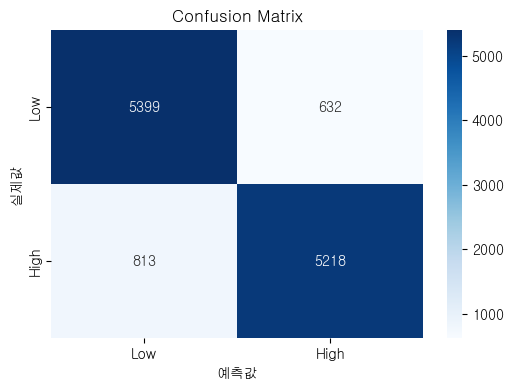

In [11]:
# 혼동 행렬 시각화
cm = confusion_matrix(y_test, y_pred)

# 시각화
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
plt.xlabel('예측값')
plt.ylabel('실제값')
plt.title('Confusion Matrix')
plt.show()

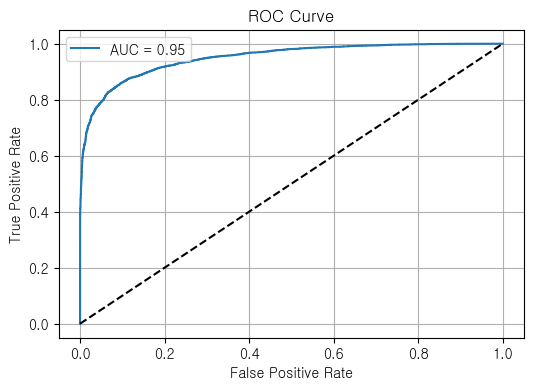

In [13]:
# ROC Curve 
from sklearn.metrics import roc_curve, roc_auc_score

# 예측 확률
y_probs = final_model.predict_proba(X_test)[:, 1]

# ROC 커브
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
auc_score = roc_auc_score(y_test, y_probs)

# 시각화
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()

C:\Users\kouls\AppData\Local\Temp\ipykernel_18792\155178189.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


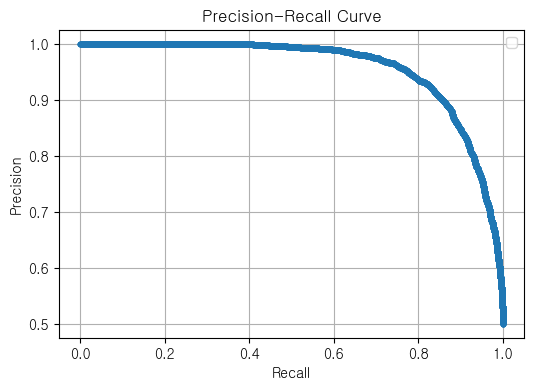

In [16]:
# PR Curve
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

plt.figure(figsize=(6, 4))
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()

C:\Users\kouls\AppData\Local\Temp\ipykernel_18792\2733220122.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importances_df.head(20), x='Importance', y='Feature', palette='viridis')


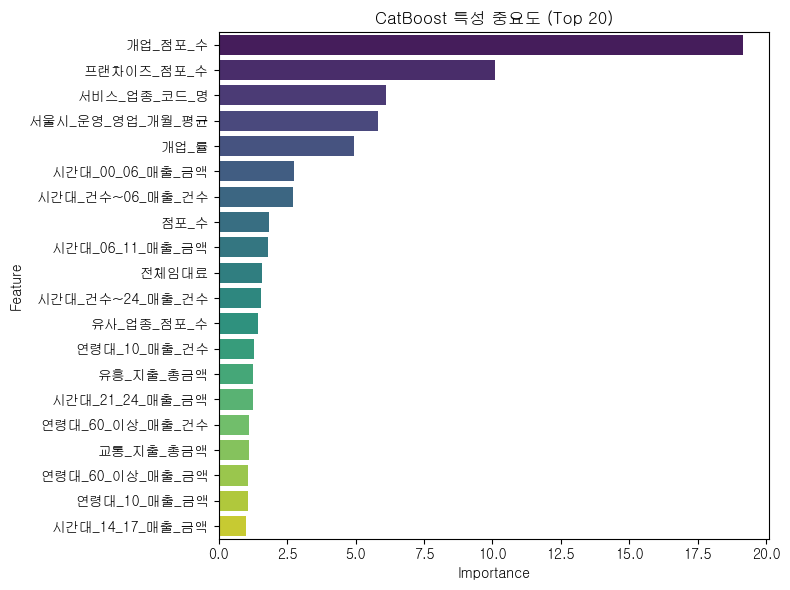

In [18]:
# 특성 중요도 시각화
feature_importances = final_model.get_feature_importance()
feature_names = X_train.columns

# 데이터프레임으로 정리
importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# 상위 20개 시각화
plt.figure(figsize=(8, 6))
sns.barplot(data=importances_df.head(20), x='Importance', y='Feature', palette='viridis')
plt.title('CatBoost 특성 중요도 (Top 20)')
plt.tight_layout()
plt.show()